In [1]:
#from torch_geometric.datasets import Planetoid
#from torch_geometric.transforms import NormalizeFeatures
import numpy as np

# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

# print()
# print(f'Dataset: {dataset}:')
# print('======================')
# print(f'Number of graphs: {len(dataset)}')
# print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

# data = dataset[0]  # Get the first graph object.

# print()
# print(data)
#int(data.x.shape[1])
#np.zeros((1,data.x.shape[1]))

In [2]:
#dir(data)

In [54]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
import torch

data = pd.read_csv(r"../data/prices.csv")

columns = [data.iloc[:, i].to_numpy() for i in range(1,len(data.columns))]
series = list(map(list, zip(*columns)))

length_train = int(len(series) * 0.8)
length_train

6424

In [55]:
pairs = np.array([(i, j) for i in range(len(columns)) for j in range(len(columns)) if i != j])
edges = pairs.tolist()

corr_mat = pd.DataFrame(data=series[:length_train]).corr()

<Axes: >

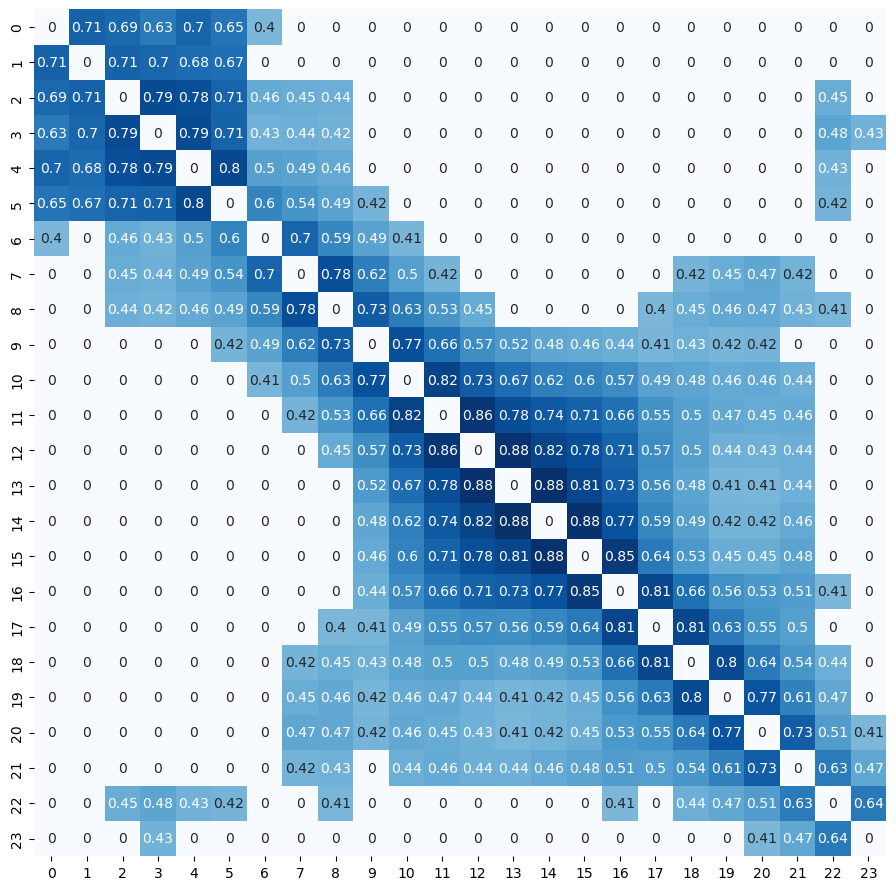

In [56]:
import seaborn as sb
import matplotlib.pyplot as plt

toll = 0.4
values_list = []
edge_list = []
adjacency = np.zeros_like(corr_mat)
for i in range(len(edges)):
    row_index = edges[i][0]
    col_index = edges[i][1]
    if abs(corr_mat.iloc[row_index, col_index]) >= toll:
        adjacency[row_index, col_index] = corr_mat.iloc[row_index, col_index]
        values_list.append(corr_mat.iloc[row_index, col_index])
        edge_list.append(edges[i])
edge_weights = np.array(values_list)

plt.figure(figsize=(11,11))
sb.heatmap(adjacency, cmap="Blues", annot=True, cbar=False)

In [6]:
# np.diagonal(adjacency)

In [57]:
# Normalization of the data
scaler = StandardScaler()
series = scaler.fit_transform(series)

In [58]:
graphs = []
lags = 3
for i in range(len(series)-lags):
    graph = Data(x=torch.tensor([series[i+j] for j in range(lags)], dtype=torch.float).view(24, lags),
                 edge_index=torch.tensor(np.array(edge_list), dtype=torch.int).view(2,len(edge_list)),
                 edge_weights=torch.tensor(edge_weights, dtype=torch.float),
                 y=torch.tensor(series[i+lags], dtype=torch.float).view(24))
    graphs.append(graph)

In [59]:
graphs[145].edge_index

tensor([[ 0,  1,  0,  2,  0,  3,  0,  4,  0,  5,  0,  6,  1,  0,  1,  2,  1,  3,
          1,  4,  1,  5,  2,  0,  2,  1,  2,  3,  2,  4,  2,  5,  2,  6,  2,  7,
          2,  8,  2, 22,  3,  0,  3,  1,  3,  2,  3,  4,  3,  5,  3,  6,  3,  7,
          3,  8,  3, 22,  3, 23,  4,  0,  4,  1,  4,  2,  4,  3,  4,  5,  4,  6,
          4,  7,  4,  8,  4, 22,  5,  0,  5,  1,  5,  2,  5,  3,  5,  4,  5,  6,
          5,  7,  5,  8,  5,  9,  5, 22,  6,  0,  6,  2,  6,  3,  6,  4,  6,  5,
          6,  7,  6,  8,  6,  9,  6, 10,  7,  2,  7,  3,  7,  4,  7,  5,  7,  6,
          7,  8,  7,  9,  7, 10,  7, 11,  7, 18,  7, 19,  7, 20,  7, 21,  8,  2,
          8,  3,  8,  4,  8,  5,  8,  6,  8,  7,  8,  9,  8, 10,  8, 11,  8, 12,
          8, 17,  8, 18,  8, 19,  8, 20,  8, 21,  8, 22,  9,  5,  9,  6,  9,  7,
          9,  8,  9, 10,  9, 11,  9, 12,  9, 13,  9, 14,  9, 15,  9, 16,  9, 17,
          9, 18,  9, 19,  9, 20, 10,  6, 10,  7, 10,  8, 10,  9, 10, 11, 10, 12,
         10, 13, 10, 14, 10,

In [60]:
lag_gnn = 90
train_size = int(0.8 * (len(graphs)-lag_gnn+1))
train_size

6350

In [61]:
train_stop = train_size+lag_gnn-1
train_stop

6439

In [62]:
test_size = len(graphs)-train_size-lag_gnn+1
test_size

1588

In [63]:
graphs_train = graphs[lag_gnn-1:train_stop]
graphs_test = graphs[train_stop:]

In [64]:
len(graphs_train)

6350

In [65]:
# from torch_geometric.loader import DataLoader
# loader = DataLoader(graphs, batch_size=500)

In [16]:
# for batch in loader:
    # print(batch)

In [17]:
# for i in range(1000):
#     if not (dataset[0].x[i].numpy() == np.zeros((1,dataset[0].x.shape[1]))).any():
#         print(i)


In [66]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from updated_models.GCNconv_up import GCNconv

In [67]:
from torch_geometric.nn import GCNConv
import torch
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, lags):
        super().__init__()
        self.lags = lags
        self.conv1 = GCNconv(in_channels=self.lags, out_channels=10, num_layers=6, num_stacks=6)
        self.lin = torch.nn.Linear(10, 1)

    def forward(self, x, edge_index, edge_weights):
        x = self.conv1(x, edge_index, edge_weights)
        x = self.lin(x)
        #x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(x)
        return x

model = GCN(lags)
print(model)

GCN(
  (conv1): GCNconv(3, 10, num_stacks=6, num_layers=6)
  (lin): Linear(in_features=10, out_features=1, bias=True)
)


  Epoch 1/100
Training loss:  1.0198524
  Epoch 2/100
Training loss:  1.0053613
  Epoch 3/100
Training loss:  0.97074556
  Epoch 4/100
Training loss:  0.9848256
  Epoch 5/100
Training loss:  0.944172
  Epoch 6/100
Training loss:  0.947374
  Epoch 7/100
Training loss:  0.9488798
  Epoch 8/100
Training loss:  0.9478971
  Epoch 9/100
Training loss:  0.9477653
  Epoch 10/100
Training loss:  0.9460634
  Epoch 11/100
Training loss:  0.94348323
  Epoch 12/100
Training loss:  0.9418144
  Epoch 13/100
Training loss:  0.93943673
  Epoch 14/100
Training loss:  0.9373337
  Epoch 15/100
Training loss:  0.93731284
  Epoch 16/100
Training loss:  0.93686354
  Epoch 17/100
Training loss:  0.9354954
  Epoch 18/100
Training loss:  0.9332801
  Epoch 19/100
Training loss:  0.9313483
  Epoch 20/100
Training loss:  0.9297181
  Epoch 21/100
Training loss:  0.9272859
  Epoch 22/100
Training loss:  0.92560434
  Epoch 23/100
Training loss:  0.92126155
  Epoch 24/100
Training loss:  0.91709876
  Epoch 25/100
Trai

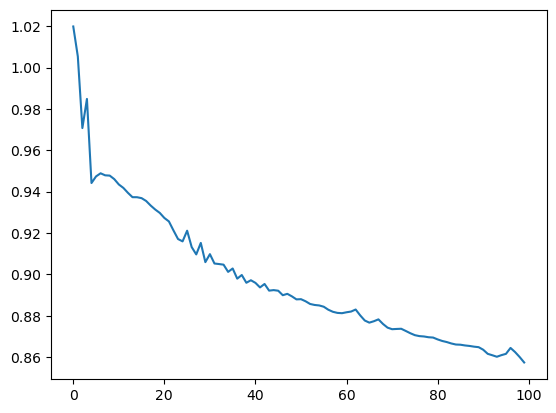

In [68]:
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.035)
loss_fn = F.mse_loss

num_epochs = 100
losses = []
graphs_index = graphs_train[0].edge_index.long()
graphs_weight = graphs_train[0].edge_weights
for epoch in range(num_epochs):
    loss = 0
    outputs = []
    print("  Epoch %d/%d" % (epoch+1,num_epochs))
    for time, snapshot in enumerate(graphs_train):
        output = model(snapshot.x, snapshot.edge_index.long(), snapshot.edge_weights)
        loss = loss + loss_fn(output.T[0], snapshot.y)
        outputs.append(scaler.inverse_transform(output.T[0].detach().cpu().numpy().reshape(1,-1)).reshape(-1))

    loss = loss/(time+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss.cpu().detach().numpy())
    
    print('Training loss: ', losses[-1])
    
plt.plot(losses)

In [48]:
target = []
for i in range(len(outputs)):
    target.append(scaler.inverse_transform(graphs[i].y.detach().cpu().numpy().reshape(1,-1)).reshape(-1))
#target

In [49]:
outputs_hourly = []
targets_hourly = []
for j in range(24):
    outhourlist = [outputs[i][j] for i in range(len(outputs))]
    tarhourlist = [target[i][j] for i in range(len(outputs))]
    outputs_hourly.append(outhourlist)
    targets_hourly.append(tarhourlist)

In [50]:
#Test set
test_outputs = []  #
test_targets = []  #
for time, snapshot in enumerate(graphs_test):
    #snapshot.to('cuda')
    output = model(snapshot.x, snapshot.edge_index.long(), snapshot.edge_weights)
    test_output = scaler.inverse_transform(output.T[0].detach().cpu().numpy().reshape(1, -1)).reshape(-1) #descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)
    test_snapshot = scaler.inverse_transform(snapshot.y.detach().cpu().numpy().reshape(1, -1)).reshape(-1) #descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)
    test_outputs.append(test_output)  #
    test_targets.append(test_snapshot)   #


In [51]:
test_output

array([-4.42706601e-17, -8.74352473e-17,  5.20129085e-01,  3.57731313e-01,
        6.20600939e-01,  4.96112585e-01, -1.31899474e-17,  3.76641750e-01,
        3.16841900e-01,  1.98944658e-01,  4.20250982e-01,  2.63776630e-01,
        2.78151244e-01,  1.49863720e-01, -8.57484804e-17,  4.24560071e-16,
        3.57262317e-17,  2.29344705e-16, -3.18549669e-17, -6.56732189e-19,
       -5.66364544e-17,  2.03450445e-16,  2.57236004e-01,  3.21533114e-01],
      dtype=float32)

In [52]:
outputs_hourly_test = []
targets_hourly_test = []
for j in range(24):
    outhourlist = [test_outputs[i][j] for i in range(len(test_outputs))]
    tarhourlist = [test_targets[i][j] for i in range(len(test_outputs))]
    outputs_hourly_test.append(outhourlist)
    targets_hourly_test.append(tarhourlist)

In [53]:
mse_test = []
for j in range(24):
    sqdiff = [(a - b)**2 for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
    mse_test.append(np.mean(sqdiff))
mse_test

[1.0557777474445713,
 0.7551020910123913,
 0.5575263710976335,
 0.9327841667130168,
 0.9625385375645168,
 1.3767643759432735,
 1.1401686113487164,
 1.1140077928385035,
 0.9939954976727261,
 0.9706012379020116,
 0.9048180208501583,
 0.7816272945773645,
 0.7004847413603394,
 0.7955110547448314,
 0.7932550284594156,
 0.8339187622112633,
 0.9312424642204232,
 0.8488201918821867,
 0.9401701099191471,
 0.934757143666376,
 0.8007612657823661,
 0.5469054204024099,
 0.8436472985751938,
 0.8249818865208028]

In [25]:
#unisco train e test
outputs_merged = [l1 + l2 for l1, l2 in zip(outputs_hourly, outputs_hourly_test)]
targets_merged = [l1 + l2 for l1, l2 in zip(targets_hourly, targets_hourly_test)]

In [102]:
# list_ids = loader._node_ids
# dict = list_ids.item()
# inverse_dict = {value: key for key, value in dict.items()}
# inverse_dict.get(0)

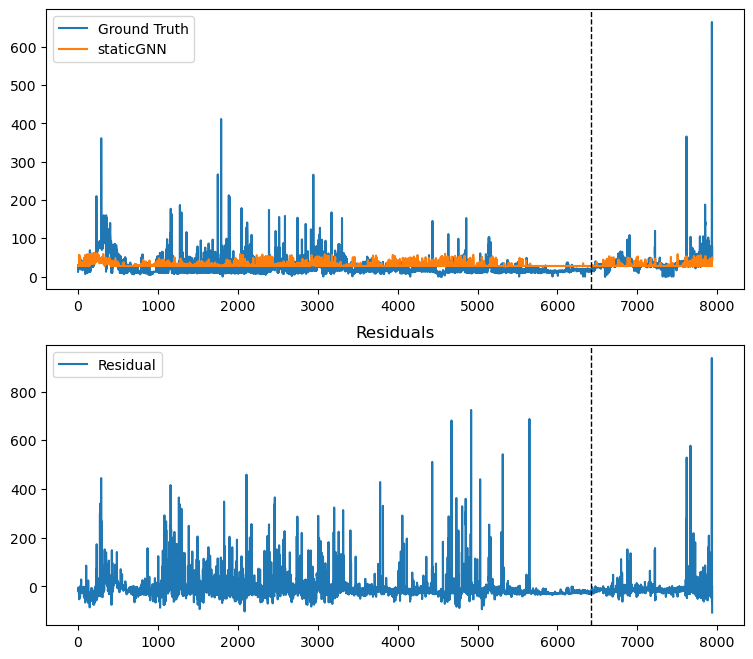

In [26]:
hour = 3

diff = [a - b for a, b in zip(targets_merged[j], outputs_merged[j])]
fig, axs = plt.subplots(2, 1, figsize=(9, 8))
axs[0].plot(targets_merged[hour], label="Ground Truth")
axs[0].plot(outputs_merged[hour], label="staticGNN")
axs[0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0].legend()
#axs[0].set_title("Daily series at "+inverse_dict[hour])
axs[1].plot(diff, label="Residual")
axs[1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1].legend()
axs[1].set_title("Residuals")
plt.show()

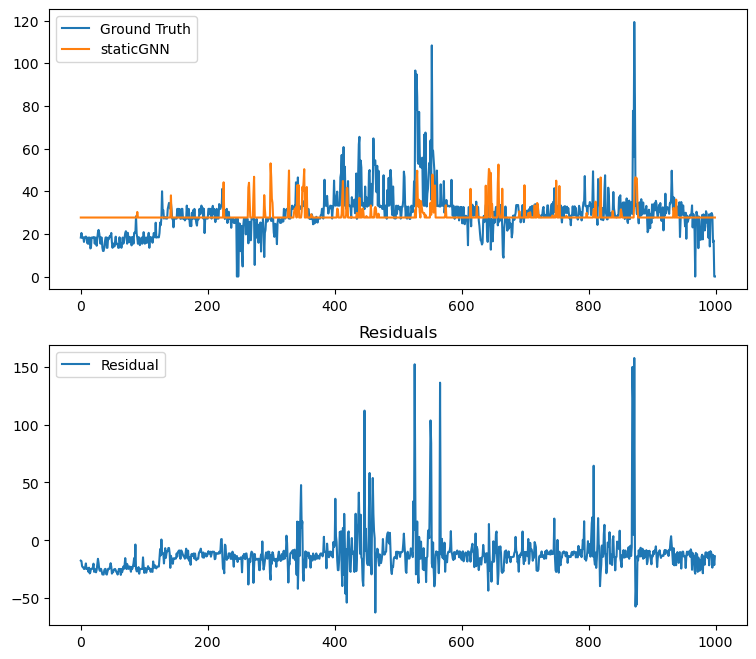

In [27]:
hour = 3

diff = [a - b for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
fig, axs = plt.subplots(2, 1, figsize=(9, 8))
axs[0].plot(targets_hourly_test[hour][:1000], label="Ground Truth")
axs[0].plot(outputs_hourly_test[hour][:1000], label="staticGNN")
axs[0].legend()
#axs[0].set_title("Daily series at "+inverse_dict[hour]+" in the test set")
axs[1].plot(diff[:1000], label="Residual")
axs[1].legend()
axs[1].set_title("Residuals")
plt.show()